# Time-resolved fitting with RL

Cell-F  EtOH

In [17]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'nh3-analysis')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)


## Set up the environment

In [18]:
import rl_model
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201341-expt.json')
final_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201349-expt.json')

data_file = os.path.join(git_dir, 'jan2023', 'data', 'r201348-time-resolved.json')
#ec_cp1 = np.loadtxt(os.path.join(project_dir, 'ec-data', 'Expt6_Summary_CP1.txt'), delimiter=',', skiprows=1).T


REVERSE = False
MAX_TIMES = 30


with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'][:MAX_TIMES])
    _data = m['data'][:MAX_TIMES]
    print("Number of times: %s" % len(_data))

 
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()


Number of times: 30
0


## View the initial time and check that the initial model makes sense

reward: -2.0309942283885243
[-0.7288671  -0.80264413 -0.73305495  0.01307269  0.01307269]


<IPython.core.display.Javascript object>


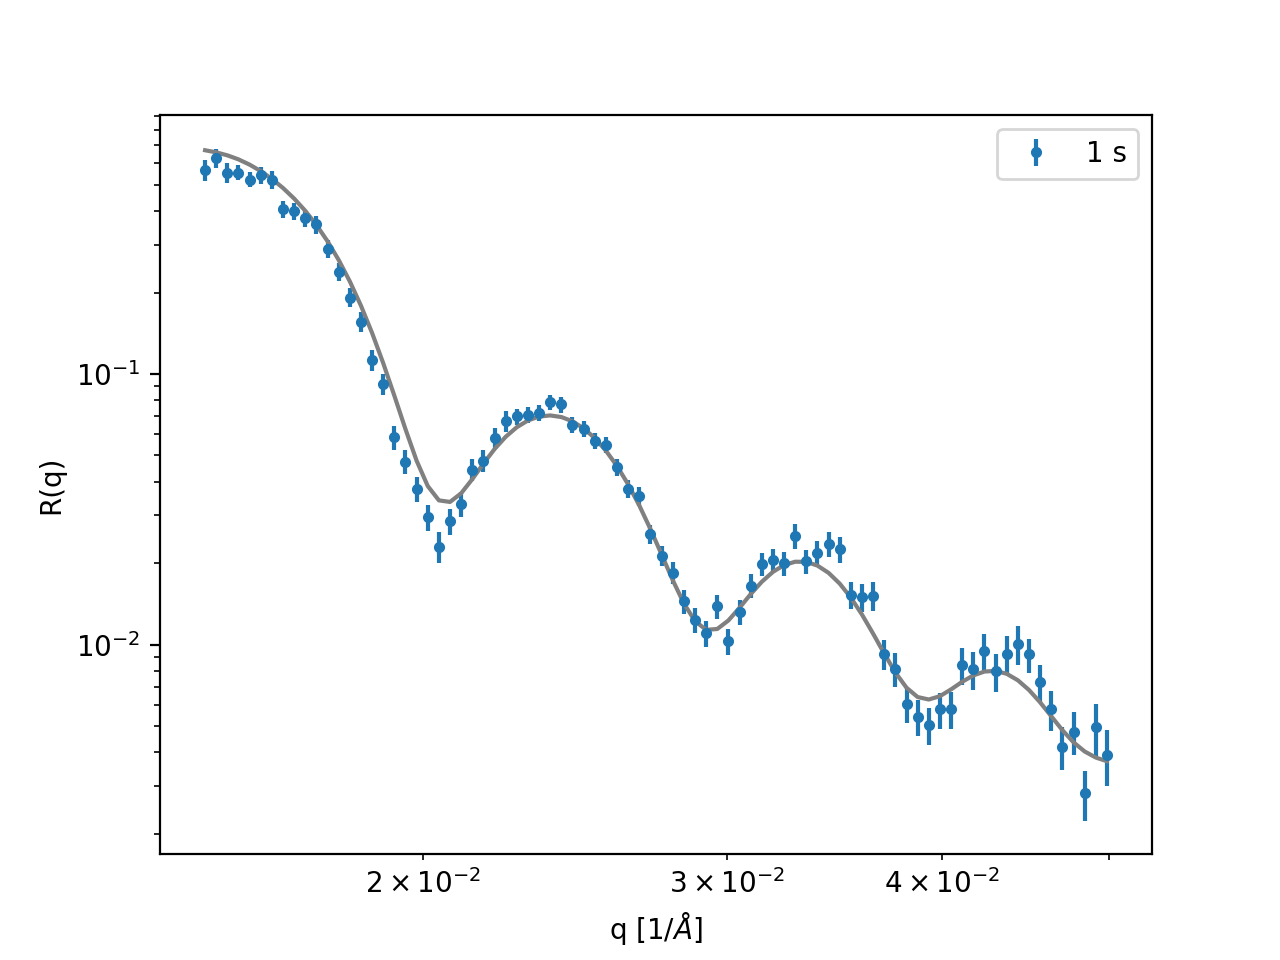

0.0

In [19]:
# choose a random action or use our initial fit
if False:
    action = env.action_space.sample() 
else:
    action = env.normalized_parameters

# take the action and get the information from the environment
new_state, reward, terminated, truncated, info = env.step(action)
print("reward: %s" % reward)
# show the current position and reward
env.render(action=action, reward=reward) 
env.plot(errors=True)

## Train or load model

In [ ]:
%%time

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
    save_freq=1000,
    save_path="./logs-201248-fwd/",
    name_prefix="rl_model",
    save_replay_buffer=False,
    save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if True:
    #model.learn(2000)
    model.learn(200000, callback=checkpoint_callback)
    model.save('SAC-201348-fwd')
else:
    model = SAC.load('UIUC-06-to-01-SAC-forward')

# Compute uncertainties

In [12]:
# There's likely a way to dig into the SAC parameters and fish out the action standard deviations

deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(5, 30, 100)
(5, 30)


## Run the agent on the time series data

In [13]:
# Evaluate the agent

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    chi2.append(env.chi2)
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (timestamps[i], obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)

Number of times: 30
Time 0 [0.]: -1.91296 [False] -1.91296
Time 30 [0.03448276]: -2.16722 [False] -4.08018
Time 60 [0.06896552]: -2.04268 [False] -6.12286
Time 90 [0.10344828]: -2.25277 [False] -8.37562
Time 120 [0.13793103]: -5.6532 [False] -14.0288
Time 150 [0.1724138]: -5.81229 [False] -19.8411
Time 180 [0.20689656]: -6.61077 [False] -26.4519
Time 210 [0.2413793]: -5.46138 [False] -31.9133
Time 240 [0.27586207]: -6.25685 [False] -38.1701
Time 270 [0.31034482]: -6.05259 [False] -44.2227
Time 300 [0.3448276]: -5.70317 [False] -49.9259
Time 330 [0.37931034]: -6.61634 [False] -56.5422
Time 360 [0.41379312]: -6.85527 [False] -63.3975
Time 390 [0.44827586]: -6.55773 [False] -69.9552
Time 420 [0.4827586]: -6.65035 [False] -76.6056
Time 450 [0.51724136]: -7.0231 [False] -83.6287
Time 480 [0.55172414]: -6.45654 [False] -90.0852
Time 510 [0.5862069]: -6.59287 [False] -96.6781
Time 540 [0.62068963]: -5.71729 [False] -102.395
Time 570 [0.6551724]: -5.70312 [False] -108.098
Time 600 [0.6896552]:

## Plot the results and compare to the Bayesian approach

<IPython.core.display.Javascript object>


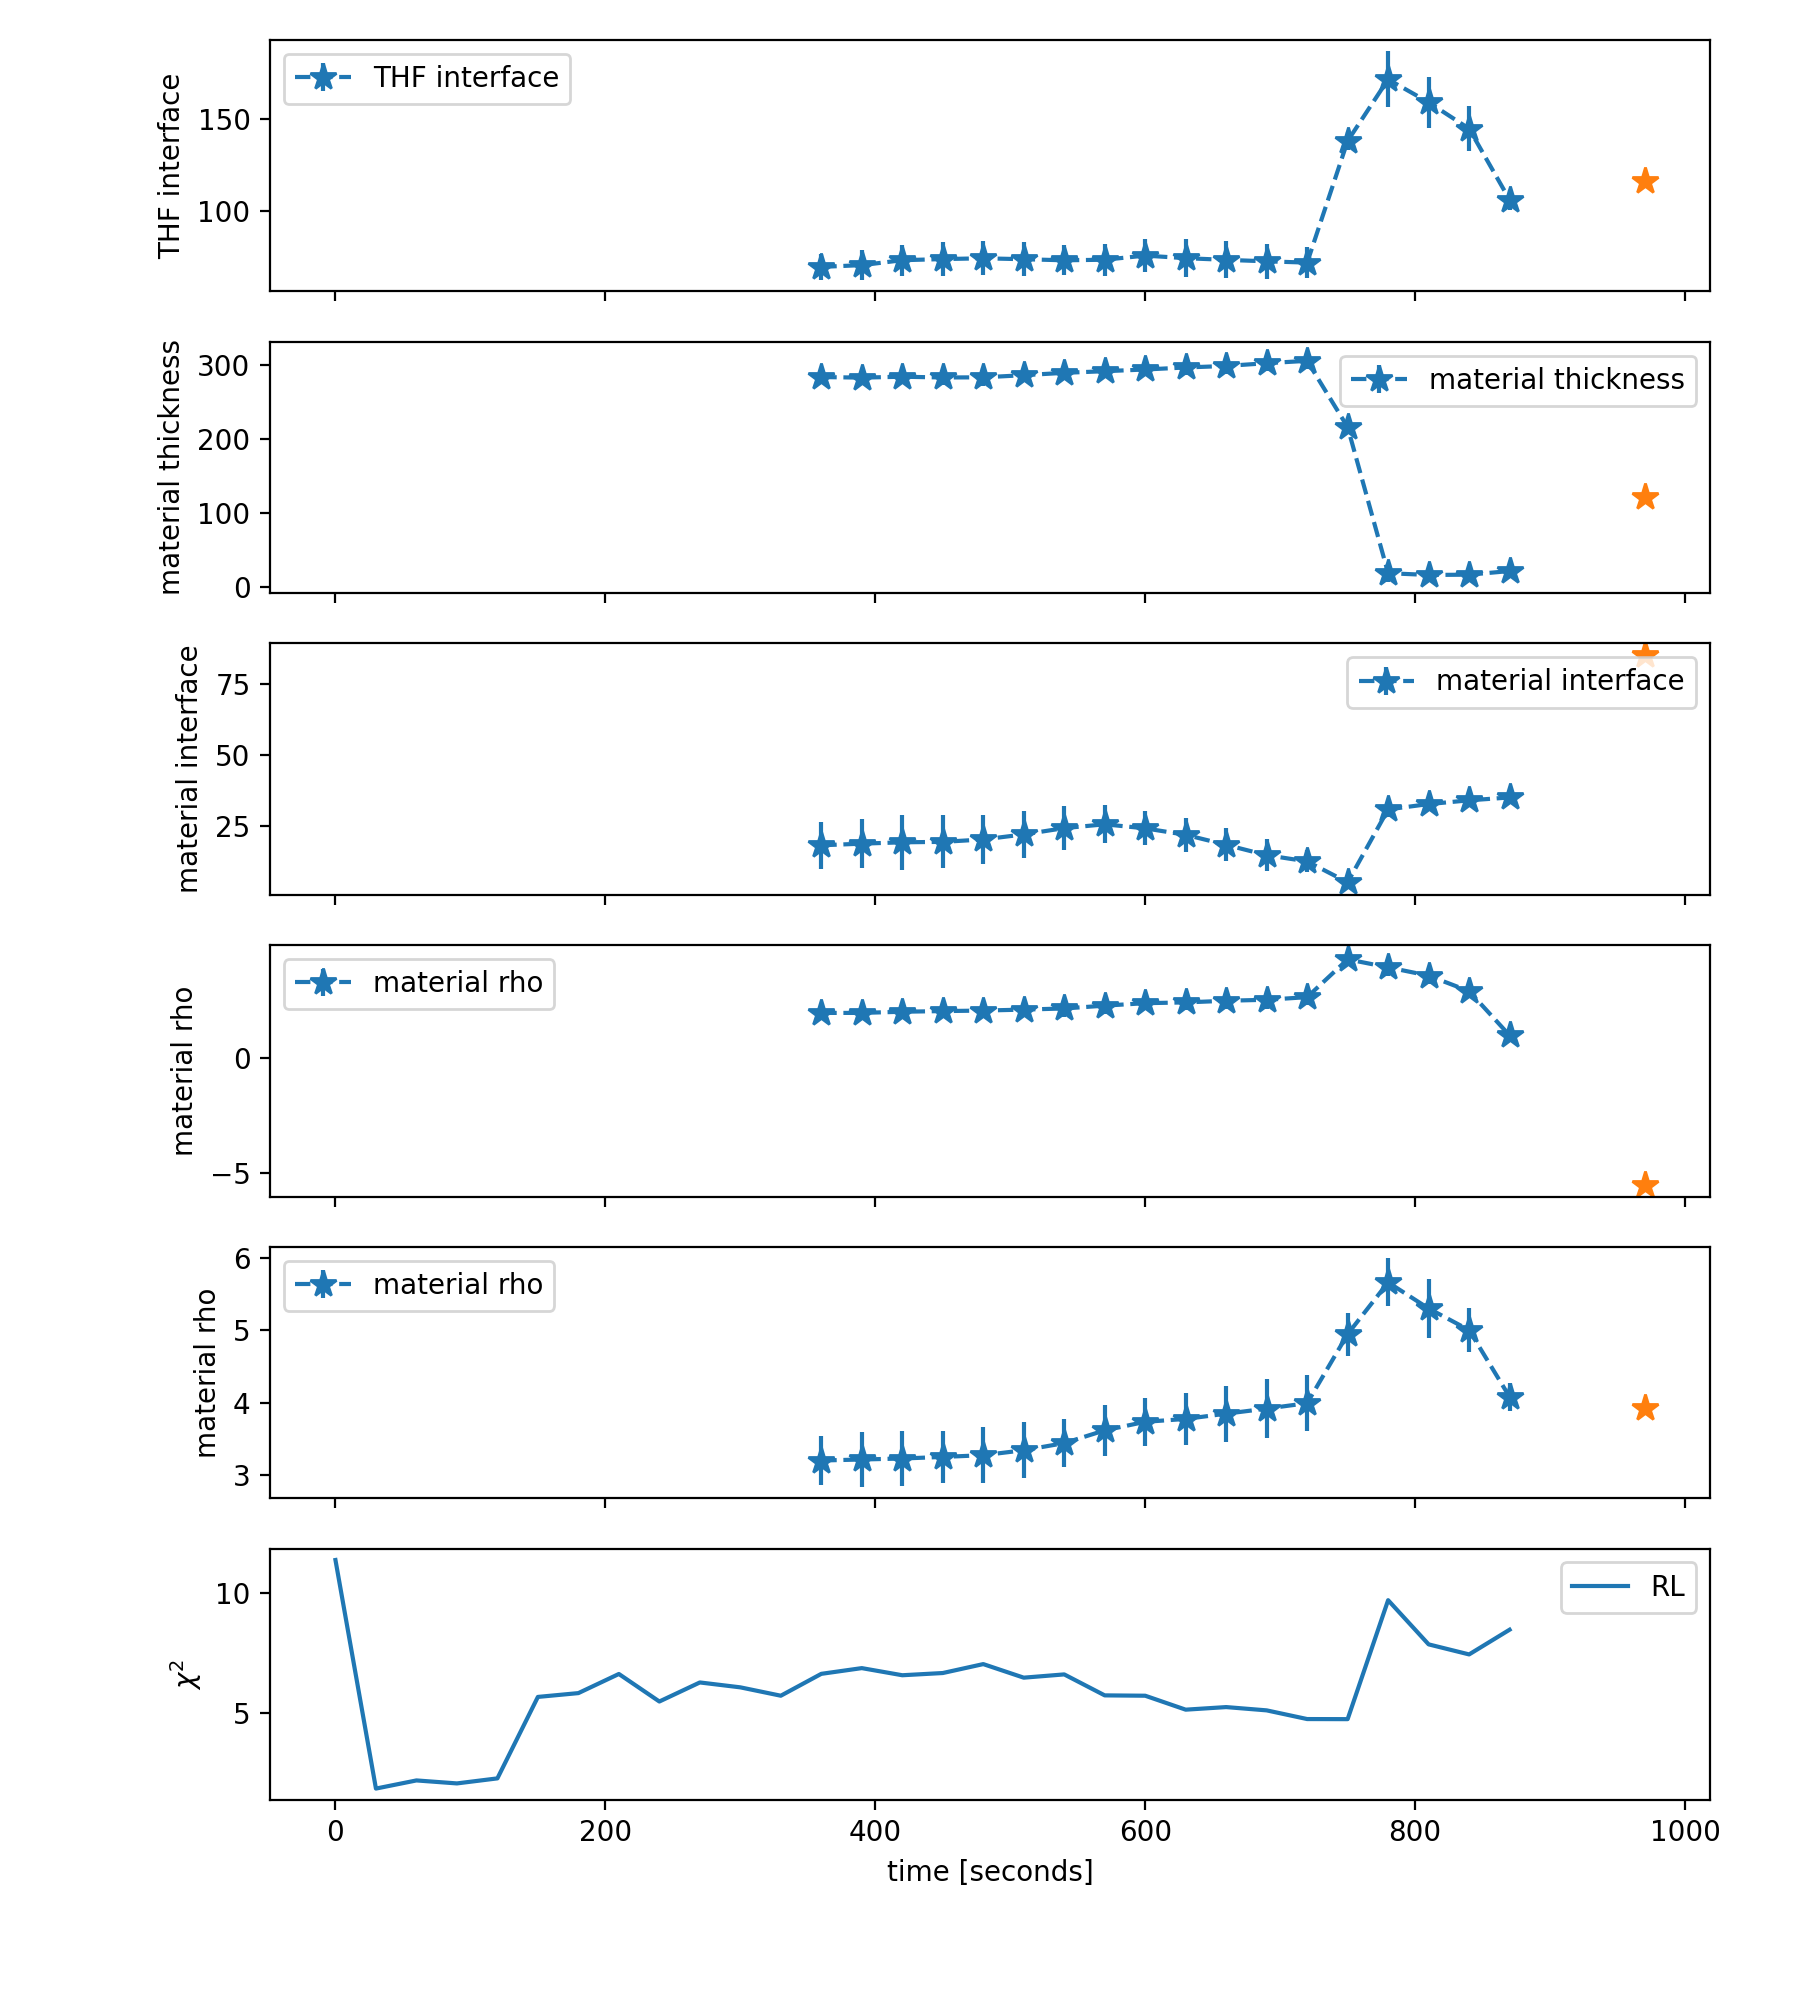

['THF interface', 'material thickness', 'material interface', 'material rho', 'material rho']


Text(0.5, 0, 'time [seconds]')

In [14]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T


t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

n_plots = pars.shape[0]+1

fig, axs = plt.subplots(n_plots, 1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)

t_min = 12

for i in range(pars.shape[0]):
    ax = plt.subplot(n_plots, 1, i+1)
    
    plt.errorbar(_times[t_min:], pars[i][t_min:], yerr=errs[i][t_min:], label=env.par_labels[i], linestyle='--', marker='*', markersize=10)

    #plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    plt.plot([t_final,], [env.end_parameters[i],], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(n_plots, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

In [15]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T


t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

n_plots = 4

fig, axs = plt.subplots(n_plots, 1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)

t_min = 12

iplot = 1
for i in [1,3,4,6]:
    ax = plt.subplot(n_plots, 1, iplot)
    
    plt.errorbar(_times[t_min:], pars[i][t_min:], yerr=errs[i][t_min:], label=env.par_labels[i], linestyle='--', marker='*', markersize=10)

    #plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    plt.plot([t_final,], [env.end_parameters[i],], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    iplot += 1


plt.legend()

plt.xlabel("time [seconds]")

<IPython.core.display.Javascript object>

['THF interface', 'material thickness', 'material interface', 'material rho', 'material rho']


IndexError: index 6 is out of bounds for axis 0 with size 5

## Nicer plot

Number of times: 30


<IPython.core.display.Javascript object>


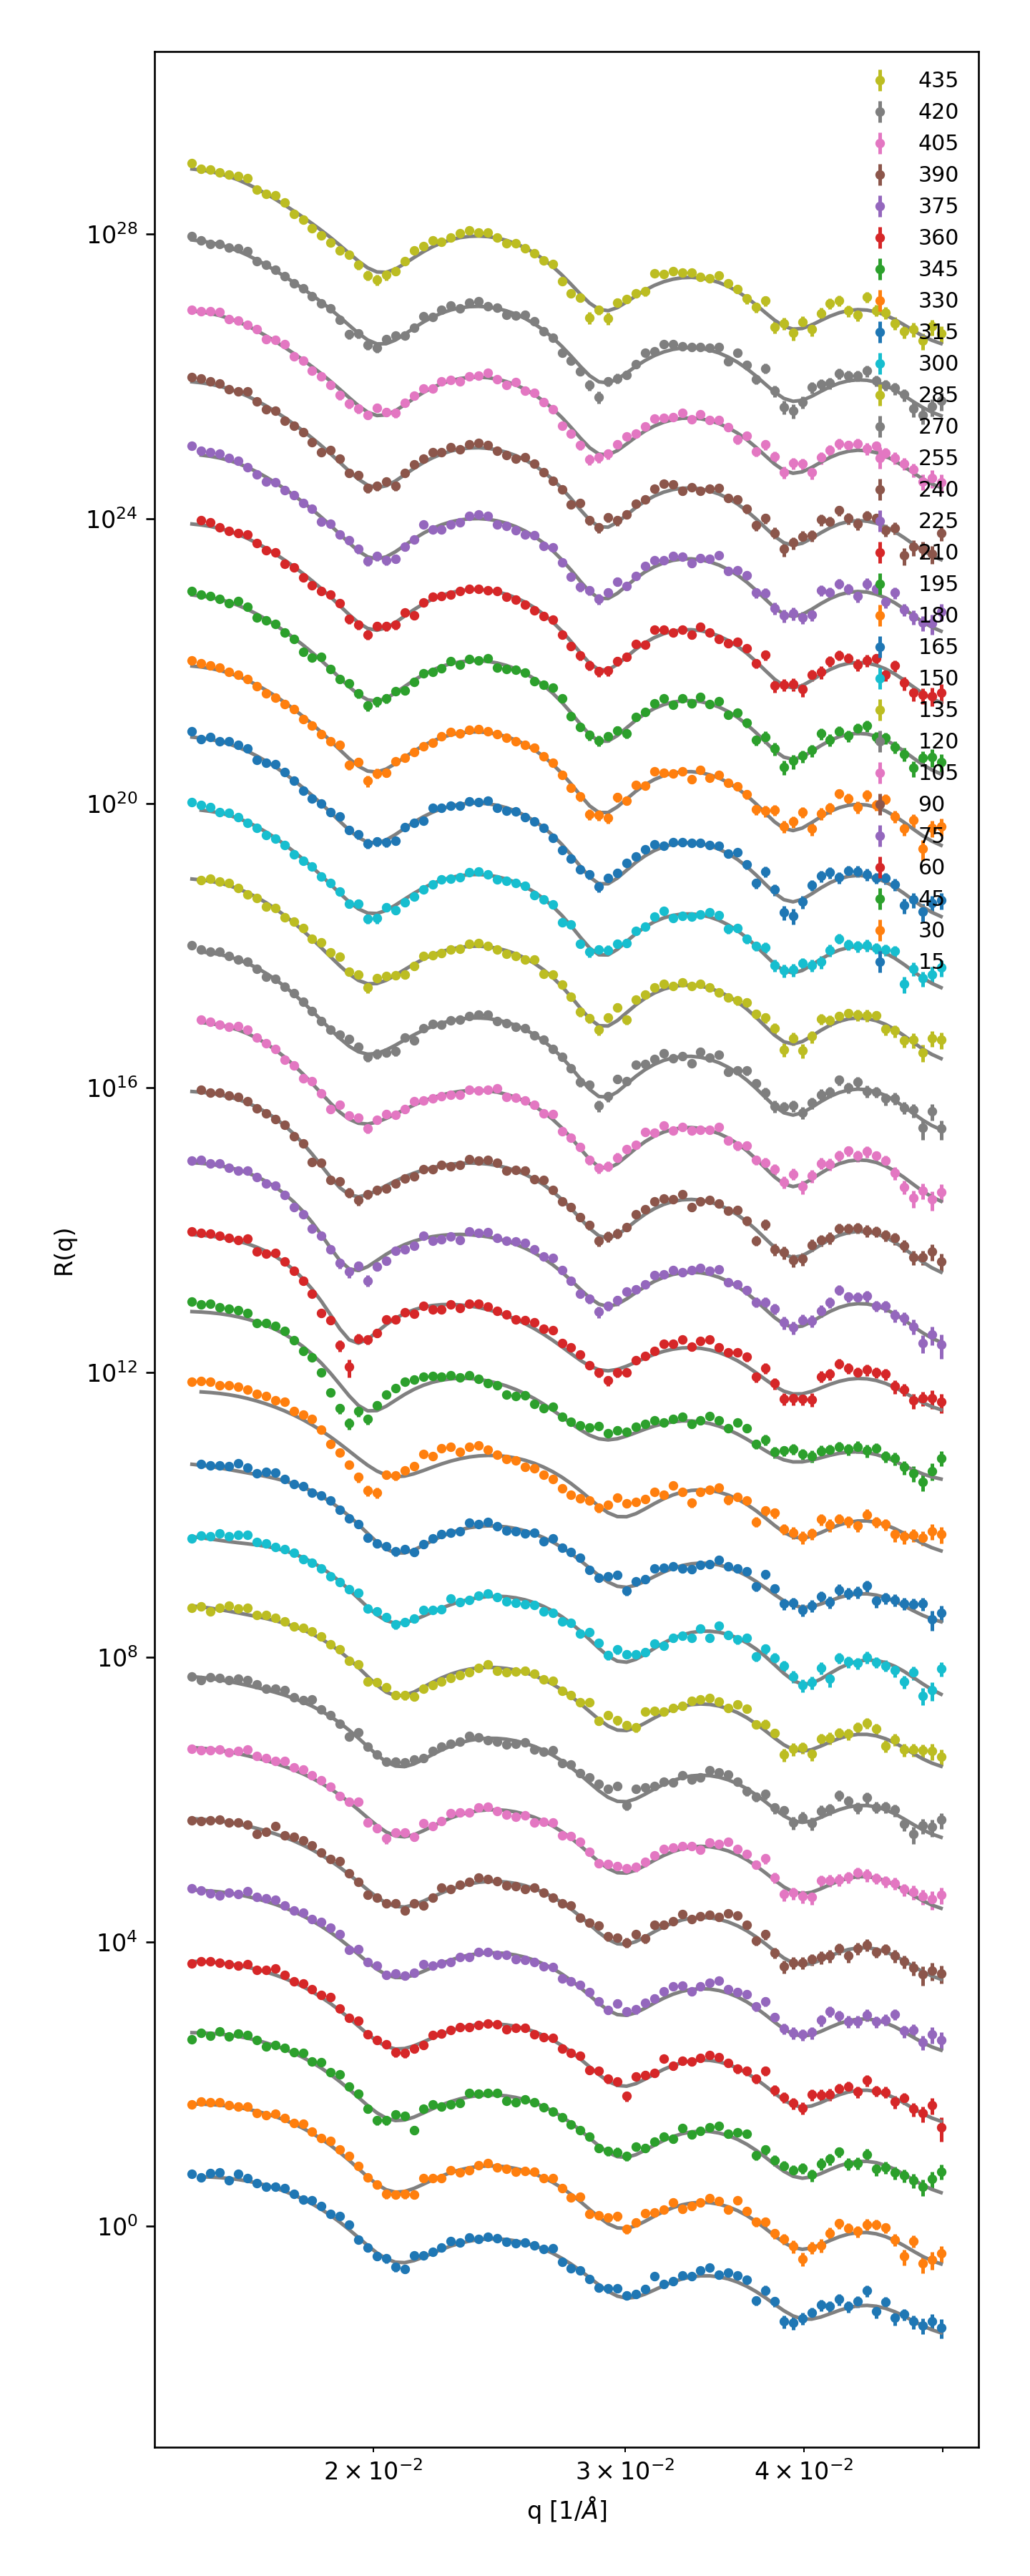

In [38]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig, ax = plt.subplots(dpi=120, figsize=(6, 15))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.05)

#for i in range(1, n_times, 1):
for i in range(1, MAX_TIMES, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False, errors=True, label=_times[i])

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 9}, loc='upper right')
#plt.xlim([0.015, 0.12])
plt.show()

Number of times: 30


<IPython.core.display.Javascript object>


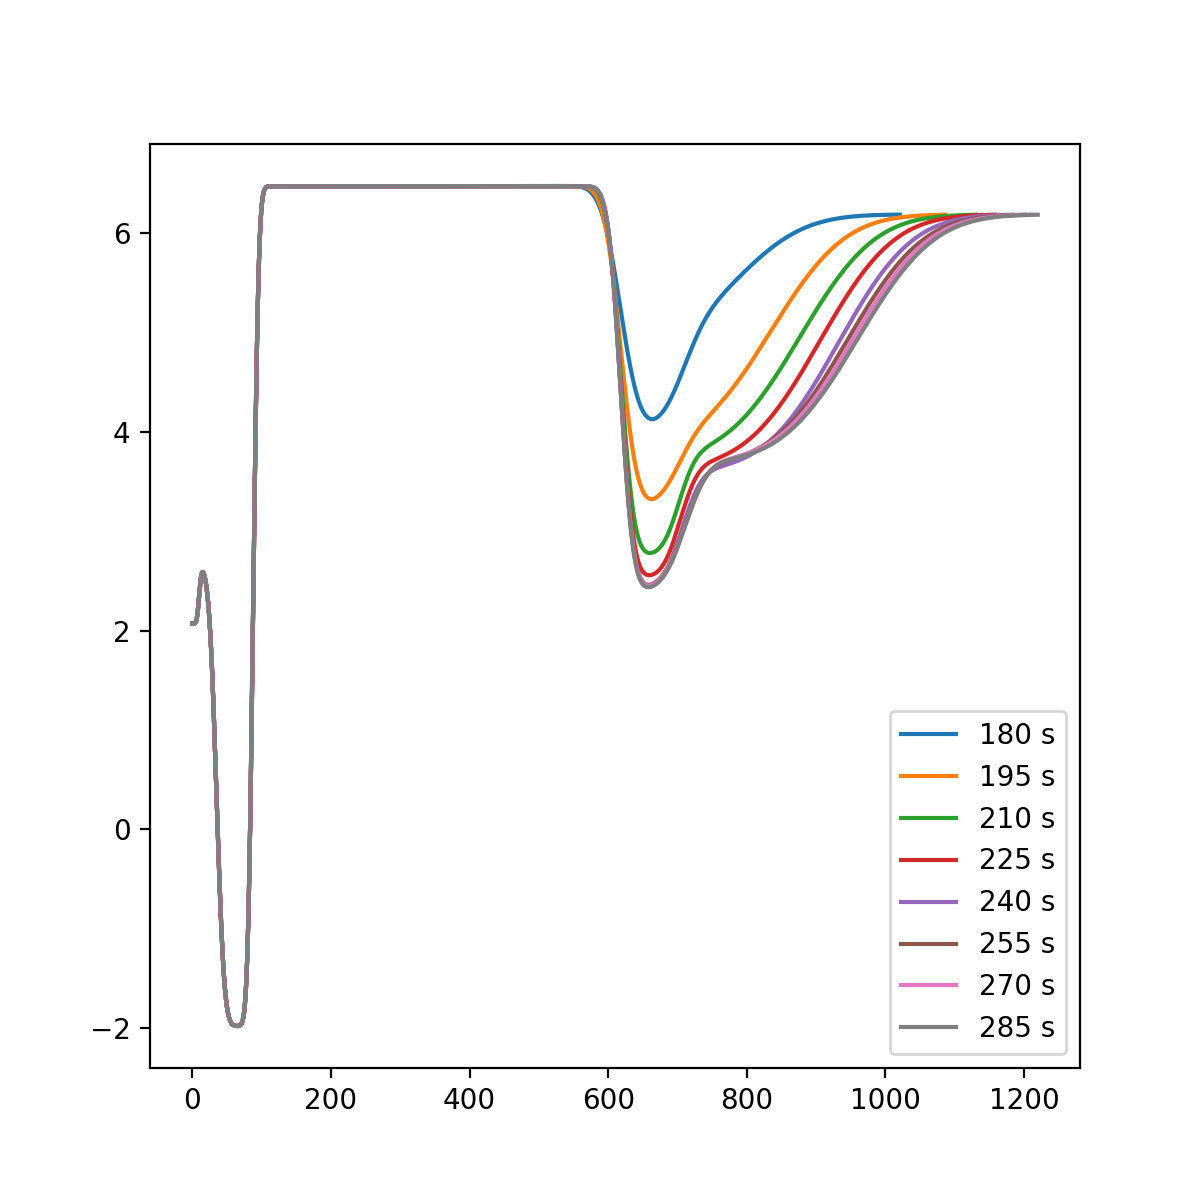

In [46]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 6))

for i in range(0, MAX_TIMES, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)
    z, sld, isld = env.ref_model.smooth_profile()
    if i > 11 and i<20:
        plt.plot(-z+z[-1], sld, label='%s s' % _times[i])
plt.legend()